https://www.wandb.com/articles/wandb-customizing-training-loops-in-tensorflow-2
https://colab.research.google.com/drive/1JCpAbjkCFhYMT7LCQ399y35TS3jlMpvM#scrollTo=w_CcwaadLI8e

In [ ]:
# Select the TensorFlow 2.0 runtime
%tensorflow_version 2.x

In [ ]:
import numpy as np
import tensorflow as tf
from tensorflow import keras
from keras.datasets import cifar10
from tensorflow.keras import regularizers
from tensorflow.keras.layers import Dense, Activation ,AveragePooling2D,GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam,SGD
from tensorflow.keras.metrics import categorical_crossentropy
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.preprocessing import image
from tensorflow.keras.models import Model
from tensorflow.keras.applications import imagenet_utils
import matplotlib.pyplot as plt
%matplotlib inline
import sklearn
import pandas as pd
from sklearn.metrics import roc_auc_score, roc_curve, auc,precision_score, recall_score,f1_score,accuracy_score
from sklearn.model_selection import StratifiedKFold
from scipy import interp
import matplotlib.pyplot as plt
from skimage import transform
import scipy.ndimage
import matplotlib.pyplot as plt

from keras.layers import Lambda, Input
from keras.models import Model, Sequential
import tensorflow as ktf
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

In [ ]:
(X_train, y_train), (X_test, y_test) = cifar10.load_data()

print('Train data shape: {}'.format(X_train.shape))
print('Test  data shape: {}'.format(X_test.shape))

Train data shape: (50000, 32, 32, 3)
Test  data shape: (10000, 32, 32, 3)


In [ ]:
image_size = 32
num_channels = 3
num_features = image_size * image_size * num_channels
num_classes = 10

In [ ]:
X_train = X_train.astype('float32')
X_test  = X_test.astype('float32')

X_train /= 255.0
mean = np.mean(X_train, axis=(0, 1, 2,3))
std = np.std(X_train, axis=(0, 1, 2,3))
X_train = (X_train - mean)/ (std+1e-7)

X_test /= 255.0

X_test =(X_test-mean) / (std+1e-7)

In [ ]:
y_train = keras.utils.to_categorical(y_train, num_classes)
y_test  = keras.utils.to_categorical(y_test,  num_classes)

print(y_train.shape)
print(y_test.shape)

(50000, 10)
(10000, 10)


In [ ]:
# plotting helper function
def plothist(hist):
    
    plt.subplot(1, 2, 1)
    plt.plot(hist.history['accuracy'])
    plt.plot(hist.history['val_accuracy'])
    plt.title('model accuracy')
    plt.ylabel('accuracy')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='lower right')

    plt.subplot(1, 2, 2)
    plt.plot(hist.history['loss'])
    plt.plot(hist.history['val_loss'])
    plt.title('model loss')
    plt.ylabel('loss')
    plt.xlabel('epoch')
    plt.legend(['train', 'test'], loc='upper right')


    plt.show()

In [ ]:
!pip install git+https://github.com/qubvel/classification_models.git

  Cloning https://github.com/qubvel/classification_models.git to /tmp/pip-req-build-hafv3zhu
  Running command git clone -q https://github.com/qubvel/classification_models.git /tmp/pip-req-build-hafv3zhu
  Running command git submodule update --init --recursive -q
  Created wheel for image-classifiers: filename=image_classifiers-1.0.0-cp36-none-any.whl size=20030 sha256=661744ccea18a35f4b35f52dbb33076b8f54813d72fbba4776e8ae58a1a70b51
  Stored in directory: /tmp/pip-ephem-wheel-cache-msdlp255/wheels/de/2b/fd/29a6d33edb8c28bc7d94e95ea1d39c9a218ac500a3cfb1b197
Successfully built image-classifiers


In [ ]:
from classification_models.tfkeras import Classifiers
ResNet18, preprocess_input = Classifiers.get('resnet18')
resnet18 = ResNet18((224, 224, 3), weights='imagenet')
#resnet18.summary() 

In [ ]:
alpha = 0.003  # weight decay coefficient

for layer in resnet18.layers:
    if isinstance(layer, keras.layers.Conv2D) or isinstance(layer, keras.layers.Dense):
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.kernel))
    if hasattr(layer, 'bias_regularizer') and layer.use_bias:
        layer.add_loss(lambda: keras.regularizers.l2(alpha)(layer.bias))

In [ ]:
x = resnet18.layers[-2].output
output = Dense(units=10,activation='softmax')(x)
model = Model(inputs=[resnet18.input], outputs=[output])

In [ ]:
for layer in model.layers[35:]:
    layer.trainable = True
for layer in model.layers[:35]:
    layer.trainable = False
#for i, layer in enumerate(model.layers):
    #print(i, layer.name, layer.trainable)

In [ ]:
newInput = Input(batch_shape=(None, 32, 32, 3))
resizedImg = Lambda(lambda image: ktf.image.resize(image, (224, 224)))(newInput)
newOutputs = model(resizedImg)
model = Model(newInput, newOutputs)

In [ ]:
# Install Weights and Biases (WnB)
!pip install wandb

In [ ]:
# Authorize Weights and Biases
!wandb login

wandb: Currently logged in as: behnejadi (use `wandb login --relogin` to force relogin)


In [ ]:
import wandb

In [ ]:
# Intialize WnB with a project name of your choice
wandb.init(project="custom_training_loops_tf-hist")

In [ ]:
BATCH_SIZE =100
STEPS_PER_EPOCH =len(X_train)//BATCH_SIZE 

boundaries = [40*STEPS_PER_EPOCH,60*STEPS_PER_EPOCH,80*STEPS_PER_EPOCH]
values = [ 0.1, 0.01,0.001,0.0001]
learning_rate_fn = keras.optimizers.schedules.PiecewiseConstantDecay(
    boundaries, values)

In [ ]:
# Define loass function and optimizer
loss_func = tf.keras.losses.SparseCategoricalCrossentropy()
optimizer = tf.keras.optimizers.SGD(learning_rate=learning_rate_fn)

In [ ]:
# Average the loss across the batch size within an epoch
train_loss = tf.keras.metrics.Mean(name="train_loss")
valid_loss = tf.keras.metrics.Mean(name="test_loss")

# Specify the performance metric
train_acc = tf.keras.metrics.SparseCategoricalAccuracy(name="train_acc")
valid_acc = tf.keras.metrics.SparseCategoricalAccuracy(name="valid_acc")

In [ ]:
# Batches of 64
train_ds = tf.data.Dataset.from_tensor_slices((X_train, y_train)).shuffle(100).batch(100)
test_ds = tf.data.Dataset.from_tensor_slices((X_test, y_test)).batch(100)

In [ ]:
# Train the model

def model_train(features, labels):
   # Define the GradientTape context
   with tf.GradientTape() as tape:
       # Get the probabilities
       predictions = model(features)
       # Calculate the loss
       loss = loss_func(labels, predictions)
   # Get the gradients
   gradients = tape.gradient(loss, model.trainable_variables)
   # Update the weights
   optimizer.apply_gradients(zip(gradients, model.trainable_variables))

   # Update the loss and accuracy
   train_loss(loss)
   train_acc(labels, predictions)

In [ ]:
# Validating the model

def model_validate(features, labels):
   predictions = model(features)
   v_loss = loss_func(labels, predictions)

   valid_loss(v_loss)
   valid_acc(labels, predictions)

In [ ]:
# Grab random images from the test and make predictions using 
# the model *while it is training* and log them using WnB
def get_sample_predictions():
    predictions = []
    images = []
    random_indices = np.random.choice(X_test.shape[0], 25)
    for index in random_indices:
        image = X_test[index].reshape(1, 224, 224, 3)
        prediction = np.argmax(model(image).numpy(), axis=1)
        prediction = CLASSES[int(prediction)]
        
        images.append(image)
        predictions.append(prediction)
    
    wandb.log({"predictions": [wandb.Image(image, caption=prediction) 
                               for (image, prediction) in zip(images, predictions)]})

In [ ]:
# Train the model for 5 epochs
for epoch in range(5):
    # Run the model through train and test sets respectively
    for (features, labels) in train_ds:
        model_train(features, labels)

    for test_features, test_labels in test_ds:
        model_validate(test_features, test_labels)
        
    # Grab the results
    (loss, acc) = train_loss.result(), train_acc.result()
    (val_loss, val_acc) = valid_loss.result(), valid_acc.result()
    
    # Clear the current state of the metrics
    train_loss.reset_states(), train_acc.reset_states()
    valid_loss.reset_states(), valid_acc.reset_states()
    
    # Local logging
    template = "Epoch {}, loss: {:.3f}, acc: {:.3f}, val_loss: {:.3f}, val_acc: {:.3f}"
    print (template.format(epoch+1,
                         loss,
                         acc,
                         val_loss,
                         val_acc))
    
    #Logging with wandb
    wandb.log({"train_loss": loss.numpy(),
               "train_accuracy": acc.numpy(),
               "val_loss": val_loss.numpy(),
               "val_accuracy": val_acc.numpy()
    })
    

Epoch 1, loss: nan, acc: 0.100, val_loss: nan, val_acc: 0.100
Epoch 2, loss: nan, acc: 0.100, val_loss: nan, val_acc: 0.100
Epoch 3, loss: nan, acc: 0.100, val_loss: nan, val_acc: 0.100
Epoch 4, loss: nan, acc: 0.100, val_loss: nan, val_acc: 0.100
Epoch 5, loss: nan, acc: 0.100, val_loss: nan, val_acc: 0.100


In [ ]:
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', patience=3)

In [ ]:
#model.save('cifar10.simplenet2.h5')
                 
#model=load_model('cifar10_01.h5')

In [ ]:
y_pred = model.predict(x_test)
labels1 = np.arange(num_classes)
print('Auc = %f' %  (roc_auc_score(y_test,  y_pred.round(),average='macro',multi_class='ovo',labels=labels1)))
print('f1_score = %f' % (f1_score(y_test, y_pred.round(), average="macro")))
print('precision = %f' % (precision_score(y_test, y_pred.round(), average="macro")))
print('recall  = %f' % (recall_score(y_test, y_pred.round(), average="macro")))
print('accuracy  = %f' % (accuracy_score(y_test, y_pred.round())))

Auc = 0.926217
f1_score = 0.878494
precision = 0.894163
recall  = 0.863700
accuracy  = 0.863700


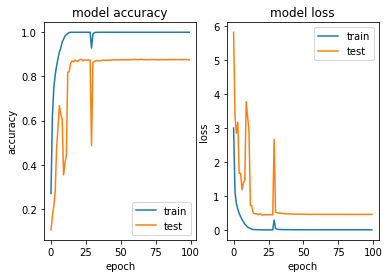

In [ ]:
plothist(history)

In [ ]:
history =model.fit(X_train, y_train, batch_size=100,
                   steps_per_epoch=len(X_train) // 100,epochs=100,
                   validation_data=(x_test,y_test))

Epoch 1/100
500/500 [==============================] - 109s 217ms/step - loss: 3.0047 - accuracy: 0.2704 - val_loss: 5.8201 - val_accuracy: 0.1053
Epoch 2/100
500/500 [==============================] - 109s 219ms/step - loss: 1.1181 - accuracy: 0.6204 - val_loss: 3.3272 - val_accuracy: 0.1687
Epoch 3/100
500/500 [==============================] - 110s 220ms/step - loss: 0.7909 - accuracy: 0.7456 - val_loss: 2.8515 - val_accuracy: 0.2136
Epoch 4/100
500/500 [==============================] - 110s 219ms/step - loss: 0.6210 - accuracy: 0.8066 - val_loss: 3.1717 - val_accuracy: 0.2761
Epoch 5/100
500/500 [==============================] - 110s 219ms/step - loss: 0.4975 - accuracy: 0.8472 - val_loss: 1.6755 - val_accuracy: 0.4726
Epoch 6/100
500/500 [==============================] - 110s 219ms/step - loss: 0.4029 - accuracy: 0.8805 - val_loss: 1.6751 - val_accuracy: 0.5675
Epoch 7/100
500/500 [==============================] - 110s 219ms/step - loss: 0.3166 - accuracy: 0.9092 - val_loss: 1